In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
import struct
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

## Génération des données

[[ 2.99611302  0.64730773]
 [ 4.25506988  1.54712952]
 [ 3.81826258  0.98315875]
 ...
 [ 0.42354657 15.60076976]
 [-0.18852642 14.76823492]
 [ 0.78885977 16.49073066]]


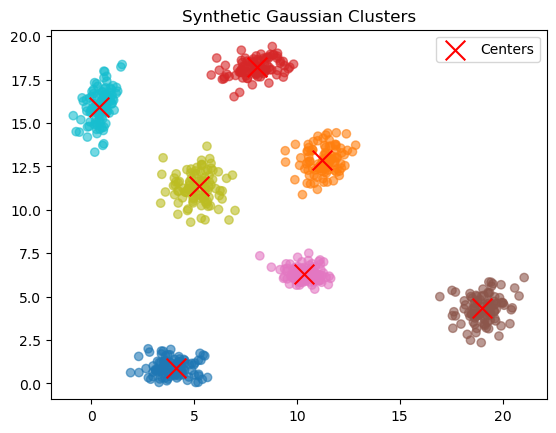

Les centres détéctés : [[ 4.09925153  0.88638095]
 [11.22123086 12.8565622 ]
 [ 8.07758445 18.19804894]
 [19.01382719  4.3198269 ]
 [10.33040064  6.29106756]
 [ 5.24908903 11.37931059]
 [ 0.39304146 15.93455484]]


In [2]:
def generate_gaussian_clusters(n_clusters, n_samples_per_cluster):
    cluster_centers = []
    while len(cluster_centers) < n_clusters:
        candidate = np.random.uniform(0, 20, size=(2,))
        if all(np.linalg.norm(candidate - np.array(c)) >= 6 for c in cluster_centers):
            cluster_centers.append(candidate)
    
    cluster_centers = np.array(cluster_centers)
    data = []
    labels = []  # Ajout pour éviter l'erreur

    for i, center in enumerate(cluster_centers):
        variance_x = np.abs(np.random.normal(0.5, 0.15))  
        variance_y = np.abs(np.random.normal(0.5, 0.15))
        cov_value = np.random.exponential(scale=0.1) * np.random.choice([-1, 1])

        cov_matrix = np.array([[variance_x, cov_value], [cov_value, variance_y]])
        cov_matrix = (cov_matrix + cov_matrix.T) / 2  
        cov_matrix = cov_matrix + 1e-3 * np.eye(2)  

        if n_samples_per_cluster > 0:  # Éviter erreur si valeur est 0
            points = np.random.multivariate_normal(center, cov_matrix, n_samples_per_cluster)
            data.append(points)
            labels.extend([i] * n_samples_per_cluster)  # Assigner des labels aux points

    if len(data) > 0:
        data = np.vstack(data)
    else:
        data = np.array([])  # Retourne un tableau vide si aucune donnée générée

    return data, np.array(labels), cluster_centers

# Génération des données avec une valeur modifiable de `n_samples_per_cluster`
n_samples_per_cluster = 100
n_clusters = 7
data, labels, centers = generate_gaussian_clusters(n_clusters=n_clusters,n_samples_per_cluster=n_samples_per_cluster)

print(data)

# Vérification que des données existent avant l'affichage
if data.size > 0:
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.scatter(np.array(centers)[:, 0], np.array(centers)[:, 1], c='red', marker='x', s=200, label='Centers')
    plt.legend()
    plt.title("Synthetic Gaussian Clusters")
    plt.show()
else:
    print("Aucune donnée générée.")

print("Les centres détéctés :", centers)


## K-means sur les données


Centres trouvés par K-Means :
[[ 7.98685343 18.16494102]
 [10.38298806  6.30659215]
 [ 3.97522217  0.90586719]
 [ 5.16445358 11.30071068]
 [ 0.44719404 16.0128803 ]
 [11.28079268 12.85263924]
 [19.0578667   4.30528819]]

Inertie (somme des distances intra-cluster) : 689.4541
Score de silhouette : 0.8175

Temps d'exécution de K-Means : 0.1879 secondes


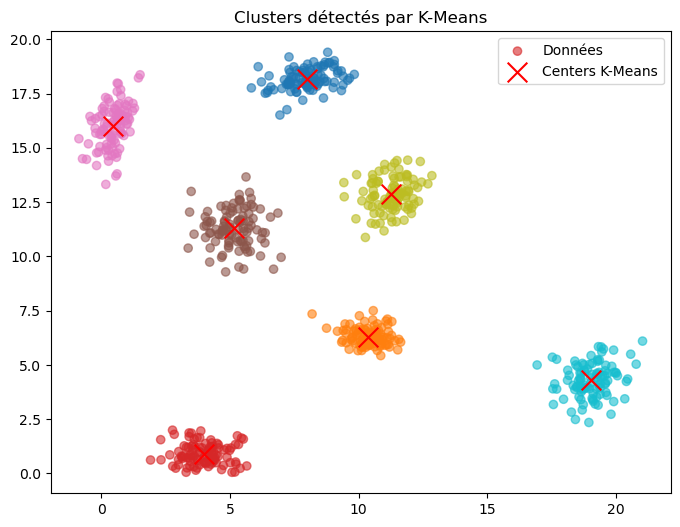

In [3]:
# Vérification qu'on a bien des données
if data.size > 0:
    # Mesurer le temps de calcul
    start_time = time.time()
    
    # Appliquer K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_pred = kmeans.fit_predict(data)
    
    end_time = time.time()
    elapsed_time = end_time - start_time  # Temps en secondes

    # Affichage des coordonnées des centres trouvés par K-Means
    print("\nCentres trouvés par K-Means :")
    print(kmeans.cluster_centers_)

    # Calcul des performances de K-Means
    inertia = kmeans.inertia_  # Somme des distances intra-cluster
    print(f"\nInertie (somme des distances intra-cluster) : {inertia:.4f}")

    if n_clusters > 1:
        silhouette = silhouette_score(data, labels_pred)
        print(f"Score de silhouette : {silhouette:.4f}")

    print(f"\nTemps d'exécution de K-Means : {elapsed_time:.4f} secondes")

    # Visualisation des clusters détectés
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels_pred, cmap="tab10", alpha=0.6, label="Données")
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centers K-Means")
    plt.legend()
    plt.title("Clusters détectés par K-Means")
    plt.show()
else:
    print("Aucune donnée générée.")

# le score de silhouette et l'inertie dans K-Means
Ils nous aident à déterminer le clustering optimal mais pas très adapté à nos données compressées
## Inertie
L’inertie mesure à quel point les points sont proches de leur centre de cluster. En d’autres termes, c’est la somme des distances entre chaque point et le centre de son cluster.
- Plus l’inertie est faible, mieux les points sont regroupés autour des centres.
- Donc l’inertie diminue toujours quand on augmente le nombre de clusters.
- On ne cherche donc pas à minimiser l’inertie seule, mais à trouver un k où la baisse d’inertie ralentit fortement.
#### Formule :
$
\text{Inertie} = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$
- $ k $ : nombre de clusters
- $ C_i $ : points appartenant au cluster $ i $
- $ \mu_i $ : centroïde du cluster $ C_i $
- $ \|x - \mu_i\|^2 $ : distance euclidienne au carré entre le point $ x $ et le centroïde
## Le score de silhouette
Il mesure à quel point chaque point est bien situé dans son cluster.
Il compare deux distances : La distance entre un point et les autres points de son propre cluster (compacité) et La distance entre ce point et les points du cluster voisin le plus proche (séparation). Le score de silhouette est compris entre **-1 et 1** : Proche de **1** → le point est bien dans son cluster. Proche de **0** → le point est entre deux clusters. **Négatif** → le point est mal classé. Donc Plus le score global est élevé, meilleure est la séparation entre clusters.
#### Notations :
- \( a(i) \) : distance moyenne entre le point \( i \) et les autres points de son cluster
- \( b(i) \) : distance moyenne entre le point \( i \) et les points du cluster voisin le plus proche

#### Formule :
$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$
#### moyenne :
$
S = \frac{1}{n} \sum_{i=1}^{n} s(i)
$



# Test du meilleur k pour faire le K-means sur les données synthétiques générées avec le score de silhouette et l'inertie

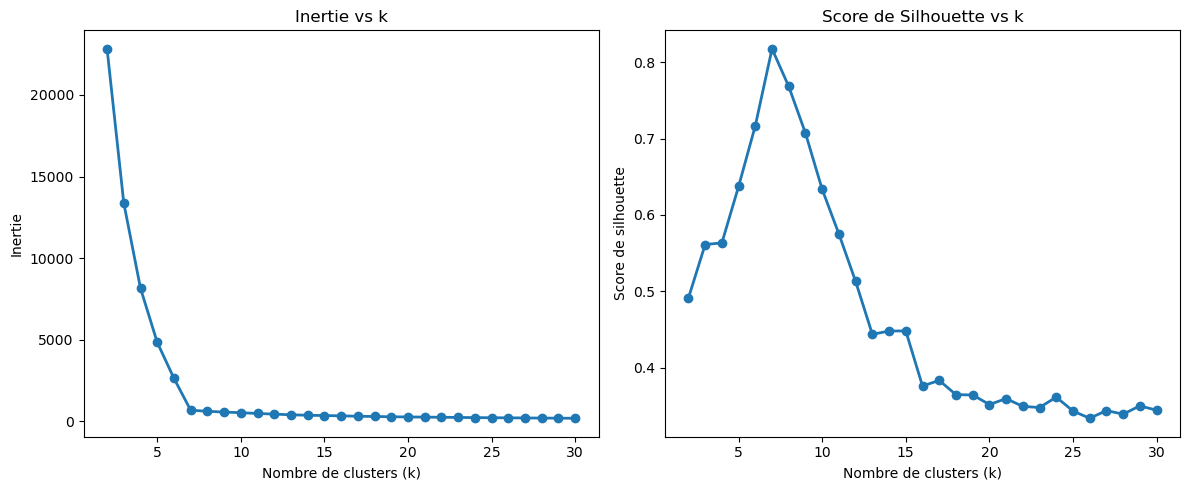

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# float_points : vos données reconstruites en float
data_arr = np.array(data)

ks = range(2, 31)
inertias    = []
silhouettes = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    labels = kmeans.fit_predict(data_arr)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(data_arr, labels))

# Tracé côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Inertie vs k
ax1.plot(ks, inertias, 'o-', linewidth=2)
ax1.set_title("Inertie vs k")
ax1.set_xlabel("Nombre de clusters (k)")
ax1.set_ylabel("Inertie")

# Silhouette vs k
ax2.plot(ks, silhouettes, 'o-', linewidth=2)
ax2.set_title("Score de Silhouette vs k")
ax2.set_xlabel("Nombre de clusters (k)")
ax2.set_ylabel("Score de silhouette")

plt.tight_layout()
plt.show()


- Ici k-means avec itération avec les scores marchent bien sur ces types de données

## X-means non optimisé appliqués sur les données initiales

Nombre de clusters détectés : 7
Taille de chaque cluster : [100, 100, 100, 100, 100, 100, 100]
Centres finaux :
 [[ 3.97522217  0.90586719]
 [10.38298806  6.30659215]
 [19.0578667   4.30528819]
 [ 7.98685343 18.16494102]
 [11.28079268 12.85263924]
 [ 0.44719404 16.0128803 ]
 [ 5.16445358 11.30071068]]


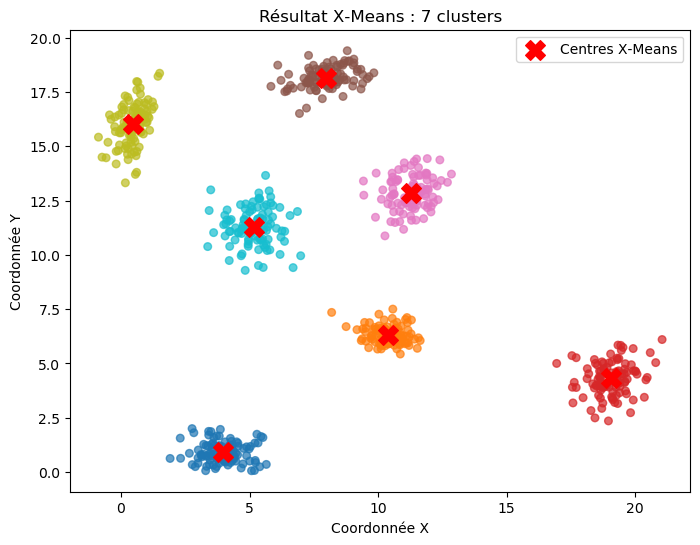

In [5]:

import random
from pyclustering.cluster.xmeans import xmeans
import numpy as np
import warnings

# Hack : faire pointer numpy.warnings vers le module standard warnings
np.warnings = warnings

data_arr_bis = np.array(data)
# 2) Choix aléatoire des centres initiaux (k_min = 2 par exemple)
k_min = 2
initial_centers = data_arr_bis[random.sample(range(len(data_arr_bis)), k_min)].tolist()

# PAS de criterion, PAS de random_state, ccore=False
xm = xmeans(data            = data_arr_bis.tolist(),
            initial_centers = initial_centers,
            kmax            = 50,
            ccore           = False)

# exécution
xm.process()

# résultats
clusters = xm.get_clusters()
centers  = xm.get_centers()
print("Nombre de clusters détectés :", len(clusters))
# Combiner en un array et construire un vecteur d'étiquettes
data_arr_bis = np.array(data_arr_bis)              # shape (n_samples, 2)
labels = np.empty(len(data_arr_bis), dtype=int)

for cluster_id, indices in enumerate(clusters):
    labels[indices] = cluster_id

# Affichage des stats
print("Taille de chaque cluster :", [len(c) for c in clusters])
print("Centres finaux :\n", np.array(centers))

# Scatter plot coloré par cluster
plt.figure(figsize=(8, 6))
plt.scatter(data_arr_bis[:, 0], data_arr_bis[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
centers_arr = np.array(centers)
plt.scatter(centers_arr[:, 0], centers_arr[:, 1],
            c='red', marker='X', s=200, label='Centres X‑Means')
plt.title(f"Résultat X‑Means : {len(clusters)} clusters")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.legend()
plt.show()


## Test général de X-means optimisé sur les types de données importantes

Avant fusion : 7 clusters
Après fusion : 7 clusters
Tailles : [100, 100, 100, 100, 100, 100, 100]
Centres finaux :
 [[ 5.16445358 11.30071068]
 [11.28079268 12.85263924]
 [ 7.98685343 18.16494102]
 [ 0.44719404 16.0128803 ]
 [10.38298806  6.30659215]
 [19.0578667   4.30528819]
 [ 3.97522217  0.90586719]]
Clusters après fusion d’overlap : 7


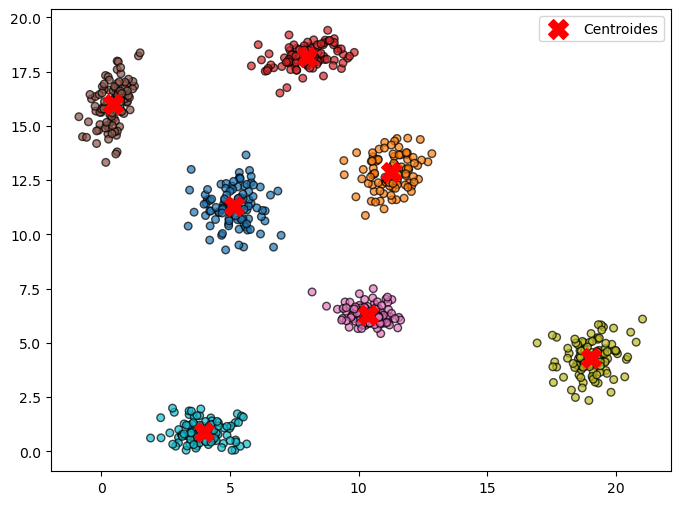

In [6]:
import warnings
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from pyclustering.cluster.xmeans import xmeans

# --- 0) Préparation des données (float_points → X_arr) ---
X_arr = np.array(data)

# --- 1) Patch numpy.warnings pour pouvoir activer C‑Core ---
import numpy as _np
_np.warnings = warnings

# --- 2) Initialisation aléatoire k_min centres ---
k_min = 2
initial_centers = X_arr[random.sample(range(len(X_arr)), k_min)].tolist()

# --- 3) Exécution de X‑Means (sans criterion, tolérance et C‑Core) ---
xm = xmeans(
    data            = X_arr.tolist(),
    initial_centers = initial_centers,
    kmax            = 50,
    tolerance       = 0.1,   # seuil de split
    ccore           = True   # moteur C‑Core plus robuste
)
xm.process()

# --- 4) Extraction des clusters initiaux et des centres ---
clusters = xm.get_clusters()
centers  = np.array(xm.get_centers())
print("Avant fusion :", len(clusters), "clusters")

# --- 5) Construction du vecteur de labels initial ---
labels = np.empty(len(X_arr), dtype=int)
for cid, pts in enumerate(clusters):
    labels[pts] = cid

# --- 6) Post‑fusion des petits clusters (<5% des points) ---
N = len(X_arr)
min_size = 0.05 * N
small_ids = [i for i, pts in enumerate(clusters) if len(pts) < min_size]

for sid in small_ids:
    dists = cdist([centers[sid]], centers)[0]
    dists[sid] = np.inf
    nearest = dists.argmin()
    labels[clusters[sid]] = nearest

# --- 7) Réindexation des labels pour qu’ils soient 0,1,2,… sans trous ---
unique = np.unique(labels)
label_map = {old: new for new, old in enumerate(unique)}
labels = np.array([label_map[l] for l in labels])

# --- 8) Reconstruction des clusters & centroïdes finaux ---
new_clusters = []
new_centers  = []

for k in range(len(unique)):
    idx = np.where(labels == k)[0]
    new_clusters.append(idx.tolist())
    new_centers.append(X_arr[idx].mean(axis=0))
new_centers = np.array(new_centers)

print("Après fusion :", len(new_clusters), "clusters")
print("Tailles :", [len(c) for c in new_clusters])
print("Centres finaux :\n", new_centers)

def merge_overlapping_clusters(X_arr, labels, centers, alpha=0.75):
    # reconstruit la liste de clusters
    def build_clusters(la):
        clusters = []
        for k in np.unique(la):
            clusters.append(np.where(la == k)[0].tolist())
        return clusters

    clusters = build_clusters(labels)

    # calcule les rayons
    def compute_radii(centers, clusters):
        radii = []
        for cid, pts in enumerate(clusters):
            pts_coords = X_arr[pts]
            radii.append(np.max(np.linalg.norm(pts_coords - centers[cid], axis=1)))
        return np.array(radii)

    labels_new = labels.copy()
    centers_new = centers.copy()
    changed = True

    while changed:
        changed = False
        clusters = build_clusters(labels_new)
        centers_new = np.array([X_arr[pts].mean(axis=0) for pts in clusters])
        radii = compute_radii(centers_new, clusters)

        # matrice distances entre centres
        D = cdist(centers_new, centers_new)
        np.fill_diagonal(D, np.inf)

        # trouve la paire la plus proche
        i, j = np.unravel_index(np.argmin(D), D.shape)
        if D[i, j] < alpha * (radii[i] + radii[j]):
            # fusionne j dans i
            labels_new[labels_new == j] = i
            # renumérote ensuite pour avoir des labels contigus
            unique = np.unique(labels_new)
            remap = {old: new for new, old in enumerate(unique)}
            labels_new = np.array([remap[l] for l in labels_new])
            changed = True

    # dernier calcul des centres
    clusters = build_clusters(labels_new)
    centers_new = np.array([X_arr[pts].mean(axis=0) for pts in clusters])

    return labels_new, centers_new

# --- Usage juste après votre X‑Means + post‑fusion initiale  ---
labels_merged, centers_merged = merge_overlapping_clusters(X_arr, labels, new_centers, alpha=0.8)

print("Clusters après fusion d’overlap :", len(np.unique(labels_merged)))

# Visualisation rapide
plt.figure(figsize=(8,6))
plt.scatter(X_arr[:,0], X_arr[:,1], c=labels_merged, cmap='tab10', s=30, alpha=0.7, edgecolor='k')
plt.scatter(centers_merged[:,0], centers_merged[:,1], marker='X', c='red', s=200, label='Centroides')
plt.legend()
plt.show()



## Objectif de X-Means

L'algorithme **X-Means** est une extension de **K-Means** qui a pour but de **déterminer automatiquement le nombre optimal de clusters (_k_)** dans un jeu de données. Contrairement à K-Means qui exige que l'utilisateur choisisse _k_ à l'avance, X-Means part d'un petit nombre de clusters et **ajuste dynamiquement leur nombre** selon la structure réelle des données.

## Étapes de fonctionnement de X-Means

### 1. Initialisation

- On commence par choisir un **nombre minimal de clusters**, noté `k_min` (souvent 2).
- L'algorithme applique **K-Means classique** avec ce `k_min` pour obtenir une première partition des données.

### 2. Tentative de division locale des clusters

Pour **chaque cluster trouvé** :

- X-Means **tente de le diviser en deux** en y appliquant un K-Means local avec `k=2`.
- Il teste donc deux modèles :
  - **Modèle 1** : le cluster tel quel.
  - **Modèle 2** : le cluster divisé en deux sous-clusters.

### 3. Évaluation statistique : BIC

Pour comparer les deux modèles, X-Means utilise un **critère statistique** :
  
- Le **BIC** (*Bayesian Information Criterion*), qui mesure la qualité d’un modèle tout en pénalisant les modèles trop complexes.

Formule générale du BIC :

$
\text{BIC} = \ln(n) \cdot p - 2 \cdot \ln(\hat{L})
$

- \( n \) : nombre d'observations
- \( p \) : nombre de paramètres (augmente avec plus de clusters)
- $ \hat{L} $ : vraisemblance du modèle

**Si le BIC du modèle divisé est meilleur**, la division est acceptée. Sinon, le cluster reste inchangé.

### 4. Itération récursive

- Chaque sous-cluster accepté peut à son tour être **candidat à une nouvelle division**.
- Le processus se répète **jusqu'à ce que** :
  - aucun cluster ne puisse être divisé avantageusement selon le BIC,
  - ou qu'un **nombre maximal de clusters (`k_max`)** soit atteint.


# BIC (Bayesian Information Criterion)

## BIC ?

Le BIC, ou critère d'information bayésien, est un outil statistique qui permet de choisir entre plusieurs modèles. Il est souvent utilisé pour déterminer combien de groupes (ou "clusters") sont présents dans un ensemble de données. Lorsqu’on fait du clustering, par exemple avec l’algorithme K-Means, on ne sait pas toujours combien de clusters choisir. Le BIC aide à choisir automatiquement un bon nombre de clusters en comparant plusieurs modèles. Il préfère un modèle qui explique bien les données, mais avec le moins de clusters possible.

## fonctionnement

Pour chaque modèle testé (par exemple, 2, 3 ou 4 clusters), le BIC :
1. Mesure à quel point le modèle correspond bien aux données.
2. Compte le nombre de paramètres utilisés dans ce modèle.
3. Combine ces deux informations pour donner un score.
Plus un modèle a de clusters, plus il devient complexe. Le BIC pénalise cette complexité excessive.
Ainsi, un modèle très précis mais trop compliqué peut avoir un BIC moins bon qu’un modèle un peu moins précis mais plus simple.
- Un **score BIC plus petit** signifie que le modèle est **meilleur**.
- Si un modèle a un BIC plus faible qu’un autre, on le préfère.
- Le BIC aide donc à éviter les modèles qui créent trop de clusters inutiles.

## application en clustering

Prenons un exemple : Un cluster contient 50 points. X-Means tente de le diviser en 2.
Il calcule : la vraisemblance de chaque configuration (1 cluster vs 2 clusters), le nombre de paramètres pour chaque configuration (chaque cluster a un centre, une variance, etc.), puis les BIC.
Si la version "2 clusters" a un BIC plus faible, on la garde.


# Transformation des données en binaire sous forme matricielle

In [7]:
# Fonction pour convertir un flottant en représentation IEEE 754 (32 bits)
def float_to_ieee754_bin(f):
    """Convertit un float en binaire IEEE 754 (32 bits)."""
    [binary] = struct.unpack(">I", struct.pack(">f", f))  # Conversion float → bits
    return np.array([int(bit) for bit in f"{binary:032b}"])  # Retourne une liste de 32 bits

# Initialisation des matrices
X = []
Y = []

if data.size > 0:
    for point in data:
        x_bin = float_to_ieee754_bin(point[0])
        y_bin = float_to_ieee754_bin(point[1])
        
        X.append(x_bin)  # Ajout de la représentation binaire de X
        Y.append(y_bin)  # Ajout de la représentation binaire de y
        print(point,x_bin,y_bin)


# Conversion en numpy array
X = np.array(X)
Y = np.array(Y)

# Affichage des résultats
print("Matrice X (représentation IEEE 754 des flottants) :")
print(X[:5])

print("\nMatrice Y (valeurs associées en binaire IEEE 754) :")
print(Y[:5])


[2.99611302 0.64730773] [0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1] [0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0]
[4.25506988 1.54712952] [0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0] [0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1]
[3.81826258 0.98315875] [0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0] [0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1]
[4.17241414 0.60392528] [0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1] [0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1]
[4.88338421 0.74996851] [0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1] [0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0]
[3.6094527 0.8115326] [0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0] [0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0]
[4.06848719 0.5303634 ] [0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0

## Algorithme de Compression **GD**

In [8]:
def generalized_deduplication_compress(X, Y, base_bits=9):
    """
    Compresses two binary matrices (X and Y) using Generalized Deduplication with base ID association.

    Args:
        X (np.ndarray): The input binary matrix for X coordinates.
        Y (np.ndarray): The input binary matrix for Y coordinates.
        base_bits (int): The number of bits to use as the base for each matrix.

    Returns:
        tuple: A tuple containing the base IDs, deviations, and the shape of the original matrices.
    """
    assert X.shape == Y.shape, "X and Y must have the same shape"
    
    original_shape = X.shape
    base_ids = []
    deviations = []
    base_dict = {}  # Dictionary to store base and their IDs
    next_base_id = 0

    for x_row, y_row in zip(X, Y):
        if len(x_row) >= base_bits and len(y_row) >= base_bits:
            # Create the base by concatenating the first `base_bits` of X and Y
            base = tuple(x_row[:base_bits]) + tuple(y_row[:base_bits])
            # Create the deviation by concatenating the remaining bits of X and Y
            deviation = np.concatenate((x_row[base_bits:], y_row[base_bits:]))

            if base in base_dict:
                base_id = base_dict[base]
            else:
                base_id = next_base_id
                base_dict[base] = base_id
                next_base_id += 1

            base_ids.append(base_id)
            deviations.append(deviation)
        else:
            # Handle cases where row length is less than base_bits
            base = tuple(x_row[:]) + tuple(y_row[:])
            deviation = np.array([])

            if base in base_dict:
                base_id = base_dict[base]
            else:
                base_id = next_base_id
                base_dict[base] = base_id
                next_base_id += 1

            base_ids.append(base_id)
            deviations.append(deviation)

    return base_ids, deviations, original_shape, base_dict

## Algorithme de décompression

In [9]:
def generalized_deduplication_decompress(base_ids, deviations, original_shape, base_dict):
    """
    Decompresses a binary matrix compressed using Generalized Deduplication with base ID association.

    Args:
        base_ids (list): The list of base IDs.
        deviations (list): The list of deviation data.
        original_shape (tuple): The shape of the original matrix.
        base_dict (dict): The dictionary containing base and their IDs.

    Returns:
        np.ndarray: The decompressed matrix as a NumPy array.
    """
    reconstructed_matrix = []
    for base_id, deviation in zip(base_ids, deviations):
        base = None
        for b, b_id in base_dict.items():
            if b_id == base_id:
                base = np.array(b)
                break

        if base is not None:
            reconstructed_row = np.concatenate((base, deviation))
            reconstructed_matrix.append(reconstructed_row)
        else:
            print("Error: Base ID not found in base_dict")
            return None

    return np.array(reconstructed_matrix).reshape(original_shape)

## Compression de nos données synthétiques plus haut : j'ai choisi 12 bits en me référent au taux de compression

In [10]:
# Compress the matrices X and Y
base_bits = 10  # Number of bits for the base
base_ids, deviations, original_shape, base_dict = generalized_deduplication_compress(X, Y, base_bits=base_bits)

print("\nBase IDs:", base_ids)
print("Deviations:", deviations)
print("Original Shape:", original_shape)
print("Base Dictionary:", base_dict)


Base IDs: [0, 1, 2, 3, 3, 2, 3, 4, 5, 3, 6, 7, 8, 7, 2, 9, 10, 6, 9, 5, 7, 11, 12, 13, 9, 7, 14, 15, 6, 16, 4, 0, 5, 2, 7, 3, 17, 6, 2, 5, 6, 18, 9, 3, 3, 12, 19, 5, 20, 10, 5, 10, 6, 10, 1, 5, 6, 9, 5, 21, 5, 22, 3, 20, 6, 5, 23, 3, 9, 17, 5, 10, 24, 1, 5, 5, 5, 25, 5, 7, 12, 1, 3, 6, 4, 6, 5, 17, 2, 5, 6, 7, 17, 7, 10, 10, 2, 20, 17, 2, 26, 26, 26, 26, 26, 26, 26, 27, 26, 27, 26, 27, 26, 26, 26, 26, 28, 26, 27, 26, 27, 26, 26, 26, 26, 26, 26, 26, 26, 27, 26, 26, 26, 26, 26, 28, 27, 26, 26, 26, 26, 26, 26, 26, 28, 26, 26, 26, 26, 26, 27, 26, 26, 26, 26, 26, 28, 26, 26, 28, 26, 26, 26, 26, 26, 26, 28, 28, 26, 26, 26, 28, 28, 26, 26, 26, 27, 26, 26, 26, 28, 27, 26, 27, 29, 26, 27, 26, 26, 26, 26, 26, 26, 28, 26, 26, 26, 26, 26, 26, 30, 30, 30, 31, 30, 31, 30, 31, 31, 31, 31, 30, 31, 31, 30, 31, 30, 30, 31, 31, 31, 30, 31, 31, 30, 31, 31, 30, 30, 31, 30, 30, 30, 30, 31, 30, 31, 31, 31, 31, 31, 31, 30, 31, 30, 30, 30, 31, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 31, 30, 30, 30, 31, 31

## Calcul du taux de compression et Test de la méthode itérative pour déterminer le nombre de bits optimal pour la base 

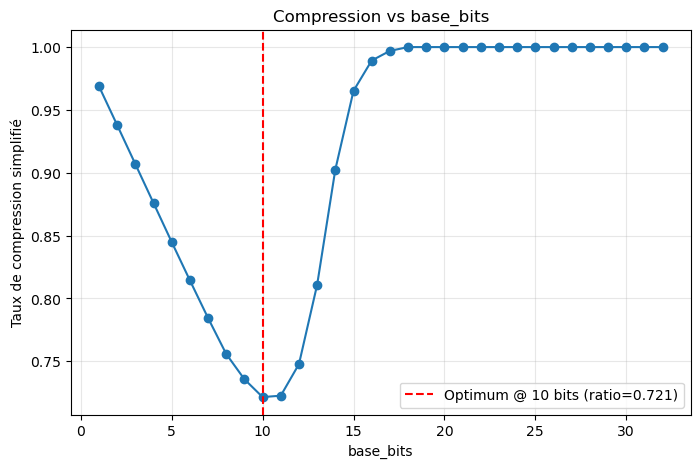

In [11]:
# 5) Calcul et tracé du ratio
X_bits = X
Y_bits = Y
n = X_bits.shape[0]
b = X_bits.shape[1] + Y_bits.shape[1]
max_bb = X_bits.shape[1]  # variant de 1 à 32
bbs = list(range(1, max_bb + 1))
ratios = []

for bb in bbs:
    _, _, _, base_dict_test = generalized_deduplication_compress(X_bits, Y_bits, bb)
    n_b = len(base_dict_test)
    l_b = 2 * bb
    l_c = b
    total_bits = n_b * l_b + n * (l_c - l_b)
    ratios.append(total_bits / (n * l_c))

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(bbs, ratios, 'o-')
best = np.argmin(ratios)
plt.axvline(bbs[best], color='red', linestyle='--',
            label=f"Optimum @ {bbs[best]} bits (ratio={ratios[best]:.3f})")
plt.xlabel("base_bits")
plt.ylabel("Taux de compression simplifié")
plt.title("Compression vs base_bits")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- On obtient un nombre de bits optimal pour la base de **10**, ce qui promet d'être cohérent

## Taux de compression avec la formule de l'article (valeurs pas cohérents à revoir) mais donne quand même un minimum pour 13 bits (pas fiable) avec les données générées (10 clusters chacun 500 samples)

→ l_b optimal = 10 bits (η = 0.9283)


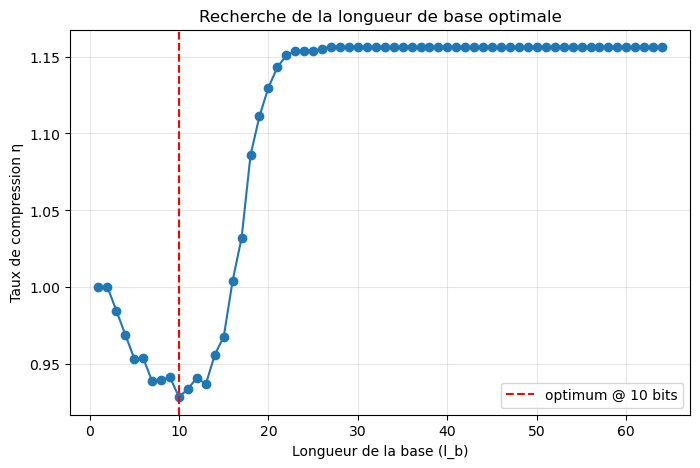

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ... Supposons que vous avez X_bits et Y_bits, shape (n, 32) chacun ... 

# 1) Construire le tableau de chunks 64 bits
n = X_bits.shape[0]
l_s = 32 + 32            # bits par échantillon (X + Y)
c   = 1                  # pas de concaténation supplémentaire
l_c = c * l_s            # bits par chunk
n_c = n // c             # nombre de chunks = n

# on convertit chaque ligne binaire en un entier
chunks = []
for xb, yb in zip(X_bits, Y_bits):
    bitstr = ''.join(map(str, xb)) + ''.join(map(str, yb))
    chunks.append(int(bitstr, 2))
chunks = np.array(chunks, dtype=np.uint64)

# 2) Boucle sur l_b de 1 à l_c
etas = []
l_b_values = range(1, l_c + 1)

for l_b in l_b_values:
    shift = l_c - l_b
    # extraire la base (les l_b bits de poids forts)
    bases_bis = chunks >> shift
    
    # nombre de bases uniques
    n_b = len(np.unique(bases_bis))
    
    # longueur de l'ID de base
    l_id = math.ceil(math.log2(n_b)) if n_b > 1 else 1
    
    # longueur de la déviation
    l_d = l_c - l_b
    
    # taux de compression η
    numerator   = n_b * l_b + n_c * (l_id + l_d)
    denominator = n * l_s
    eta = numerator / denominator
    
    etas.append(eta)

# 3) On repère le minimum de η
best_idx = int(np.argmin(etas))
best_l_b = l_b_values[best_idx]
best_eta = etas[best_idx]
print(f"→ l_b optimal = {best_l_b} bits (η = {best_eta:.4f})")

# 4) Tracé de η vs l_b
plt.figure(figsize=(8, 5))
plt.plot(l_b_values, etas, marker='o')
plt.axvline(best_l_b, color='red', linestyle='--',
            label=f"optimum @ {best_l_b} bits")
plt.xlabel("Longueur de la base (l_b)")
plt.ylabel("Taux de compression η")
plt.title("Recherche de la longueur de base optimale")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Fonction pour calculer les centroides et le poids associé

In [13]:
def compare_bitwise(a, b):
    """Compare deux tableaux de bits et retourne le plus petit et le plus grand bit à bit (poids fort à faible)."""
    for i in range(len(a)):
        if a[i] < b[i]:
            return a, b
        elif a[i] > b[i]:
            return b, a
    return a, b  # Si identiques

def compute_centroids(base_ids, deviations):
    unique_ids = np.unique(base_ids)
    centroids = {}
    weighted_centroids = {"max_deviation": {}, "mean_deviation": {}, "prod_deviation": {}}
    
    for uid in unique_ids:
        # Récupérer les indices correspondant à l'ID courant
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        # Extraire les valeurs
        selected_values = [deviations[i] for i in indices]
        # Trouver manuellement min et max en comparant bit par bit
        min_val = selected_values[0]
        max_val = selected_values[0]
        
        for val in selected_values:
            min_val, _ = compare_bitwise(min_val, val)
            _, max_val = compare_bitwise(max_val, val)
        
        print("Min:", min_val, "Max:", max_val)
        
         # Calculer la moyenne entre min et max (en entier)
        min_int = int(''.join(map(str, min_val)), 2)
        max_int = int(''.join(map(str, max_val)), 2)
        
        print("Min int:", min_int, "Max int:", max_int)
        mean_int = (min_int + max_int) // 2  # Moyenne des deux entiers
        
        # Convertir la moyenne en binaire
        mean_bin = bin(mean_int)[2:]  # On enlève le préfixe '0b'
        
        # Calculer le centroïde comme la moyenne entre min et max
        centroid = [int(bit) for bit in mean_bin.zfill(len(min_val))]  # Compléter avec des zéros si nécessaire
        
        centroids[uid] = centroid

        # Compute the maximum deviation (bitwise max - min for each dimension)
        max_deviations = []
        for i in range(len(min_val)):
            max_bit = 0
            min_bit = 1
            for val in selected_values:
                if val[i] > max_bit:
                    max_bit = val[i]
                if val[i] < min_bit:
                    min_bit = val[i]
            max_deviations.append(max_bit - min_bit)
        
        # Store the results for the maximum deviation
        print(f"Max Deviations for ID {uid}: {max_deviations}")
        
        # Calculate weighted centroids using different methods
        
        # (i) Maximum of the maximum deviations
        max_weighted_centroid = [centroid[i] * max_deviations[i] for i in range(len(centroid))]
        weighted_centroids["max_deviation"][uid] = max_weighted_centroid
        
        # (ii) Mean of the maximum deviations
        mean_deviation = np.mean(max_deviations)
        mean_weighted_centroid = [centroid[i] * mean_deviation for i in range(len(centroid))]
        weighted_centroids["mean_deviation"][uid] = mean_weighted_centroid
        
        # (iii) Product of the maximum deviations
        prod_deviation = np.prod(max_deviations)
        prod_weighted_centroid = [centroid[i] * prod_deviation for i in range(len(centroid))]
        weighted_centroids["prod_deviation"][uid] =  prod_weighted_centroid
    
    return centroids, weighted_centroids
    
centroids, weighted_centroids = compute_centroids(base_ids, deviations)
print("Centroids:", centroids)
print("Weighted Centroids:", weighted_centroids)

Min: [0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 1] Max: [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 1 1 0]
Min int: 5567781319043 Max int: 17523808777718
Max Deviations for ID 0: [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
Min: [0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0
 1 0 1 0 1 1 1] Max: [1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1
 0 0 1 0 0 1 0]
Min int: 2243617491031 Max int: 13361513961874
Max Deviations for ID 1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Min: [0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1
 0 1 0 1 1 1 1] Max: [1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1
 0 0 0 1 0 0 1]
Min int: 19277

## Reconstitution des données compressées sous forme de points afin de pouvoir visualiser mais pour l'instant sous forme binaire

In [14]:
def reconstruct_points(base_dict, centroids, base_bits=10, centroid_bits=22):
    """
    Reconstructs the original points (X, Y) from the centroids and base dictionary.

    Args:
        base_dict (dict): Dictionary mapping bases to their IDs.
        centroids (dict): Dictionary mapping base IDs to their centroids.
        base_bits (int): Number of bits used for the base.
        centroid_bits (int): Number of bits in the centroid.

    Returns:
        list: A list of reconstructed points [(X1, Y1), (X2, Y2), ...].
    """
    reconstructed_points = []

    # Inverse the base_dict to map IDs back to bases
    id_to_base = {v: k for k, v in base_dict.items()}

    for base_id, centroid in centroids.items():
        # Retrieve the base corresponding to the base_id
        base = id_to_base[base_id]

        # Split the base into its X and Y components
        base_x = list(base[:base_bits])  # Convert tuple slice to list (X part of the base)
        base_y = list(base[base_bits:])  # Convert tuple slice to list (Y part of the base)

        # Split the centroid into its X and Y components
        centroid_x = centroid[:centroid_bits]  # First `centroid_bits` bits (X part of the centroid)
        centroid_y = centroid[centroid_bits:]  # Last `centroid_bits` bits (Y part of the centroid)

        # Reconstruct X coordinate
        x_bits = base_x + centroid_x  # Concatenate base X and centroid X

        # Reconstruct Y coordinate
        y_bits = base_y + centroid_y  # Concatenate base Y and centroid Y

        # Append the reconstructed point (X, Y)
        reconstructed_points.append((x_bits, y_bits))

    return reconstructed_points

## Reconstition des points binaires

In [15]:
# Reconstruction des points
reconstructed_points = reconstruct_points(base_dict, centroids)
print("Reconstructed Points:", reconstructed_points[0])
print("Taille", len(reconstructed_points))

Reconstructed Points: ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0])
Taille 76


## Transformation de binaire en flottants

In [16]:
def ieee754_bin_to_float(bits):
    """
    Convertit une représentation binaire IEEE 754 (32 bits) en flottant.

    Args:
        bits (list): Une liste de 32 bits (0 ou 1).

    Returns:
        float: La valeur flottante correspondante.
    """
    # Convertir les bits en une chaîne binaire
    binary_str = ''.join(map(str, bits))
    
    # Convertir la chaîne binaire en un entier non signé
    integer_value = int(binary_str, 2)
    
    # Interpréter l'entier comme un flottant IEEE 754 (32 bits)
    [float_value] = struct.unpack(">f", struct.pack(">I", integer_value))
    
    return float_value

## Conversion des points reconstruits binaires en flottants 

In [17]:
# Conversion des points reconstruits en flottants
def convert_reconstructed_points_to_float(reconstructed_points):
    """
    Convertit les points reconstruits (en bits IEEE 754) en coordonnées flottantes.

    Args:
        reconstructed_points (list): Liste des points sous forme de tuples de listes de bits [(X_bits, Y_bits), ...].

    Returns:
        list: Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
    """
    float_points = []
    for x_bits, y_bits in reconstructed_points:
        # Convertir les bits en flottants
        x_float = ieee754_bin_to_float(x_bits)
        y_float = ieee754_bin_to_float(y_bits)
        float_points.append((x_float, y_float))
    return float_points

## Application de la conversion sur nos données binaires

In [18]:
# Conversion des points reconstruits en flottants
float_points = convert_reconstructed_points_to_float(reconstructed_points)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

Points reconstruits en flottants :
(2.6563024520874023, 0.5125081539154053)
(4.887048721313477, 1.8169236183166504)
(3.553541898727417, 0.9068315029144287)
(4.6444220542907715, 0.6545462608337402)
(2.5674474239349365, 1.681603193283081)
(4.690370559692383, 1.360693097114563)
(3.4586639404296875, 1.0939905643463135)
(3.5683822631835938, 0.7302961349487305)
(5.189371585845947, 0.06660192459821701)
(4.3014302253723145, 0.9551178216934204)
(3.63546085357666, 1.6643465757369995)
(5.076186180114746, 0.056075625121593475)
(4.904733180999756, 0.3322293162345886)
(2.9944441318511963, 0.3998497426509857)
(5.397060394287109, 0.23928473889827728)
(3.2916243076324463, 0.05813708156347275)
(1.9083168506622314, 0.6215492486953735)
(4.627857685089111, 0.40336236357688904)
(2.8877854347229004, 0.2449939101934433)
(2.771573543548584, 0.33662477135658264)
(3.459491491317749, 0.28731581568717957)
(3.715163469314575, 0.2487996518611908)
(3.670201539993286, 0.15320834517478943)
(2.65842342376709, 0.85834205

## Fonction pour afficher les données compressées sur le graphe

In [19]:
# Affichage des points reconstruits
def plot_reconstructed_points(float_points):
    """
    Affiche les points reconstruits dans un graphique 2D.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
    """
    # Extraire les coordonnées X et Y
    x_coords, y_coords = zip(*float_points)

    # Créer le graphique
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, color='blue', s=50, alpha=0.7, edgecolor='k')
    plt.title("Points Reconstruits", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)

    # Afficher le graphique
    plt.show()



## Application pour visualiser les données compressées

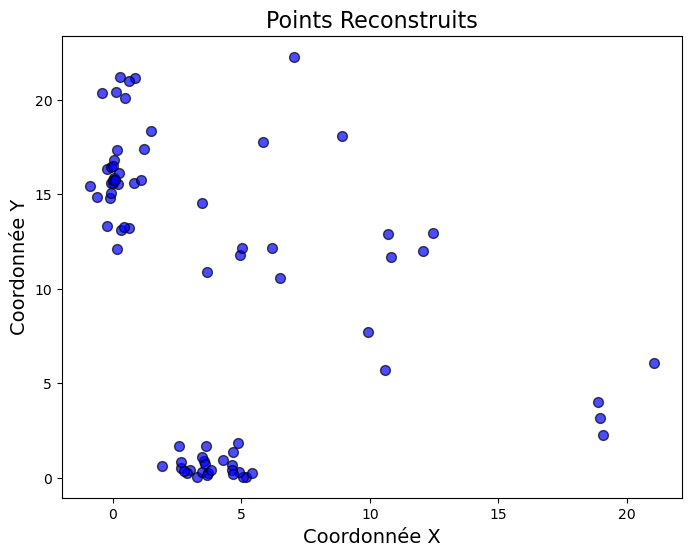

In [20]:
plot_reconstructed_points(float_points)

## Fonction qui fait k-means et affiche le graphe

In [21]:
# Application de K-Means et visualisation
def apply_kmeans_and_plot(float_points, n_clusters):
    """
    Applique K-Means sur les points reconstruits et affiche les clusters ainsi que les métriques.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
        n_clusters (int): Nombre de clusters pour K-Means.
    """
    # Conversion en tableau NumPy
    points_array = np.array(float_points)

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Initialisation et application de K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array)

    # Mesurer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time

    # Centres des clusters
    cluster_centers = kmeans.cluster_centers_

    # Inertie (somme des distances intra-cluster)
    inertia = kmeans.inertia_

    # Score de silhouette (si plus de 1 cluster)
    if n_clusters > 1:
        silhouette = silhouette_score(points_array, labels)
    else:
        silhouette = None  # Le score de silhouette n'est pas défini pour un seul cluster

    # Afficher les résultats
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (somme des distances intra-cluster) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"\nTemps d'exécution de K-Means : {execution_time:.4f} secondes")

    # Visualisation des clusters
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        # Sélectionner les points appartenant au cluster actuel
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)

    # Afficher les centres des clusters
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")

    # Ajouter des détails au graphique
    plt.title("Clustering avec K-Means", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

## Affichage avec k-means en donnant le nombre de clusters selon la silhouette

/Users/fallou/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Centres trouvés par K-Means :
[[ 3.80799712  0.62549897]
 [ 0.13295132 15.32156463]
 [11.09062338 10.48926131]
 [19.48399305  3.89117819]
 [ 0.48888813 20.36478588]
 [ 4.9702791  12.02271605]
 [ 7.26750787 19.37220065]]

Inertie (somme des distances intra-cluster) : 184.3532973440228
Score de silhouette : 0.6932115381176337

Temps d'exécution de K-Means : 0.1468 secondes


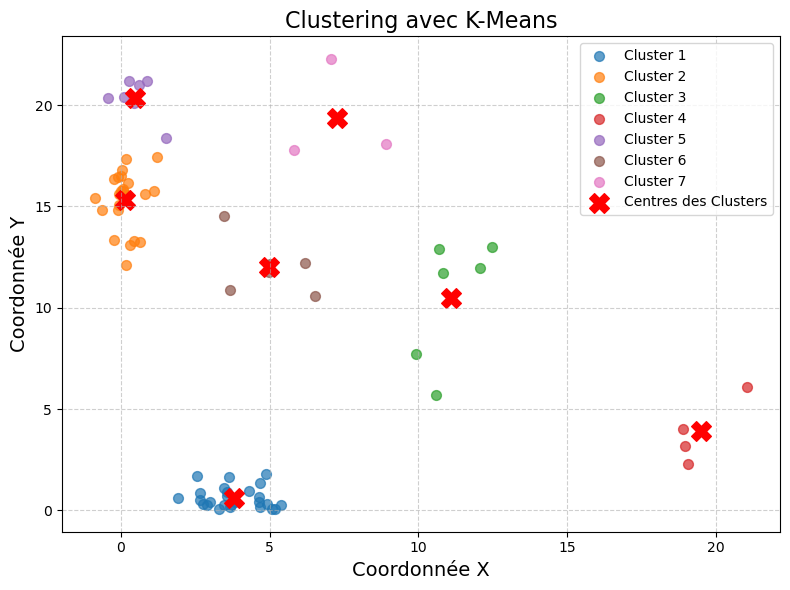

In [22]:
apply_kmeans_and_plot(float_points, n_clusters = 7)

## Test du k optimal pour bien faire le clustering : malheureusement on obtient un k pas très cohérent car les graphse obtenus ne sont pas aussi cohérents 

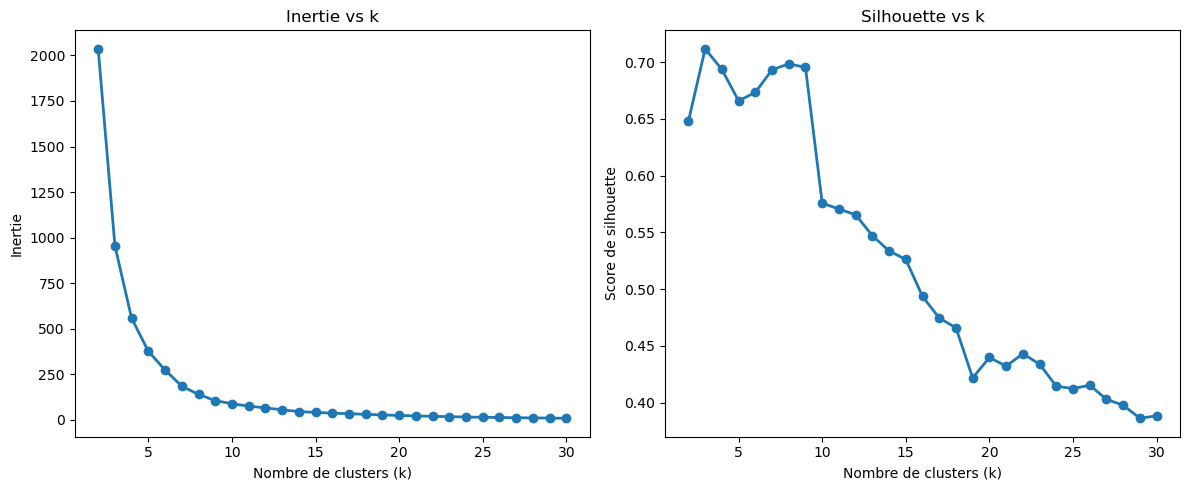

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# float_points : vos données reconstruites en float
float_points_bis = np.array(float_points)

ks = range(2, 31)
inertias = []
silhouettes = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    labels = kmeans.fit_predict(float_points_bis)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(float_points_bis, labels))

# Tracés
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Inertie
ax1.plot(ks, inertias, 'o-', linewidth=2)
ax1.set(title='Inertie vs k', xlabel='Nombre de clusters (k)', ylabel='Inertie')

# Silhouette
ax2.plot(ks, silhouettes, 'o-', linewidth=2)
ax2.set(title='Silhouette vs k', xlabel='Nombre de clusters (k)', ylabel='Score de silhouette')

plt.tight_layout()
plt.show()


## Application de X-means pas optimisé sur ces données

Nombre de clusters détectés : 4
Taille de chaque cluster : [12, 26, 4, 34]
Centres finaux :
 [[ 8.48579158 11.55243055]
 [ 3.80799712  0.62549897]
 [19.48399305  3.89117819]
 [ 0.67504377 16.61265741]]


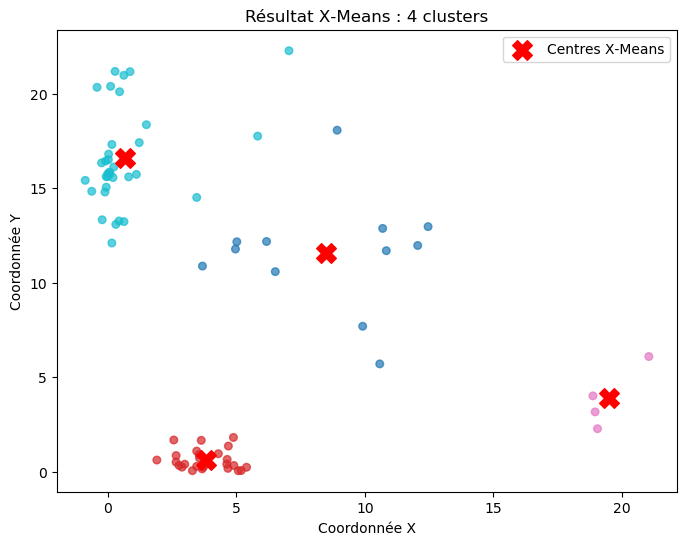

In [24]:

import random
from pyclustering.cluster.xmeans import xmeans

float_points_bis= np.array(float_points)
# 2) Choix aléatoire des centres initiaux (k_min = 2 par exemple)
k_min = 2
initial_centers = float_points_bis[random.sample(range(len(float_points_bis)), k_min)].tolist()

# PAS de criterion, PAS de random_state, ccore=False
xm = xmeans(data            = float_points_bis.tolist(),
            initial_centers = initial_centers,
            kmax            = 50,
            ccore           = False)

# exécution
xm.process()

# résultats
clusters = xm.get_clusters()
centers  = xm.get_centers()
print("Nombre de clusters détectés :", len(clusters))
# Combiner en un array et construire un vecteur d'étiquettes
float_points_bis = np.array(float_points_bis)              # shape (n_samples, 2)
labels = np.empty(len(float_points_bis), dtype=int)

for cluster_id, indices in enumerate(clusters):
    labels[indices] = cluster_id

# Affichage des stats
print("Taille de chaque cluster :", [len(c) for c in clusters])
print("Centres finaux :\n", np.array(centers))

# Scatter plot coloré par cluster
plt.figure(figsize=(8, 6))
plt.scatter(float_points_bis[:, 0], float_points_bis[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
centers_arr = np.array(centers)
plt.scatter(centers_arr[:, 0], centers_arr[:, 1],
            c='red', marker='X', s=200, label='Centres X‑Means')
plt.title(f"Résultat X‑Means : {len(clusters)} clusters")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.legend()
plt.show()


## Application du X-means sur ces données compressées

Avant fusion : 4 clusters
Après fusion : 4 clusters
Tailles : [12, 4, 26, 34]
Centres finaux :
 [[ 8.48579158 11.55243055]
 [19.48399305  3.89117819]
 [ 3.80799712  0.62549897]
 [ 0.67504377 16.61265741]]


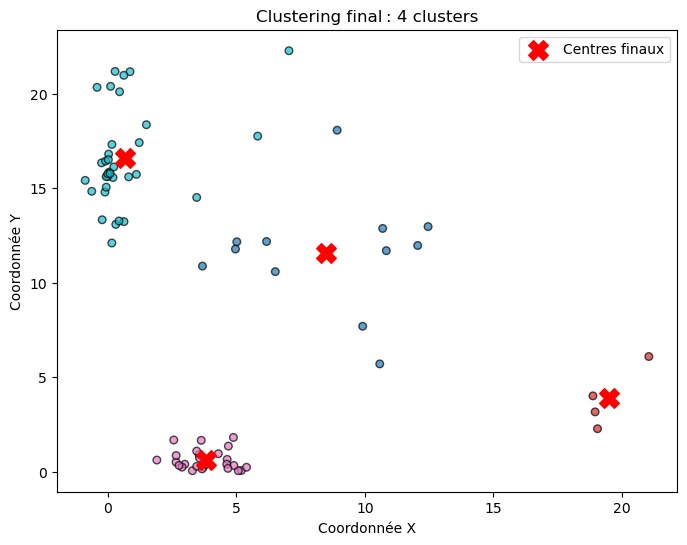

In [25]:
import warnings
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from pyclustering.cluster.xmeans import xmeans

# --- 0) Préparation des données (float_points → X_arr) ---
X_arr = np.array(float_points)

# --- 1) Patch numpy.warnings pour pouvoir activer C‑Core ---
import numpy as _np
_np.warnings = warnings

# --- 2) Initialisation aléatoire k_min centres ---
k_min = 2
initial_centers = X_arr[random.sample(range(len(X_arr)), k_min)].tolist()

# --- 3) Exécution de X‑Means (sans criterion, tolérance et C‑Core) ---
xm = xmeans(
    data            = X_arr.tolist(),
    initial_centers = initial_centers,
    kmax            = 50,
    tolerance       = 0.3,   # seuil de split
    ccore           = True   # moteur C‑Core plus robuste
)
xm.process()

# --- 4) Extraction des clusters initiaux et des centres ---
clusters = xm.get_clusters()
centers  = np.array(xm.get_centers())
print("Avant fusion :", len(clusters), "clusters")

# --- 5) Construction du vecteur de labels initial ---
labels = np.empty(len(X_arr), dtype=int)
for cid, pts in enumerate(clusters):
    labels[pts] = cid

# --- 6) Post‑fusion des petits clusters (<5% des points) ---
N = len(X_arr)
min_size = 0.025 * N
small_ids = [i for i, pts in enumerate(clusters) if len(pts) < min_size]

for sid in small_ids:
    dists = cdist([centers[sid]], centers)[0]
    dists[sid] = np.inf
    nearest = dists.argmin()
    labels[clusters[sid]] = nearest

# --- 7) Réindexation des labels pour qu’ils soient 0,1,2,… sans trous ---
unique = np.unique(labels)
label_map = {old: new for new, old in enumerate(unique)}
labels = np.array([label_map[l] for l in labels])

# --- 8) Reconstruction des clusters & centroïdes finaux ---
new_clusters = []
new_centers  = []

for k in range(len(unique)):
    idx = np.where(labels == k)[0]
    new_clusters.append(idx.tolist())
    new_centers.append(X_arr[idx].mean(axis=0))
new_centers = np.array(new_centers)

print("Après fusion :", len(new_clusters), "clusters")
print("Tailles :", [len(c) for c in new_clusters])
print("Centres finaux :\n", new_centers)


# --- 9) Visualisation finale ---
plt.figure(figsize=(8, 6))
plt.scatter(X_arr[:, 0], X_arr[:, 1], c=labels, cmap='tab10',
            s=30, alpha=0.7, edgecolor='k')
plt.scatter(new_centers[:, 0], new_centers[:, 1],
            c='red', marker='X', s=200, label='Centres finaux')
plt.title(f"Clustering final : {len(new_clusters)} clusters")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.legend()
plt.show()


ValueError: x and y must be the same size

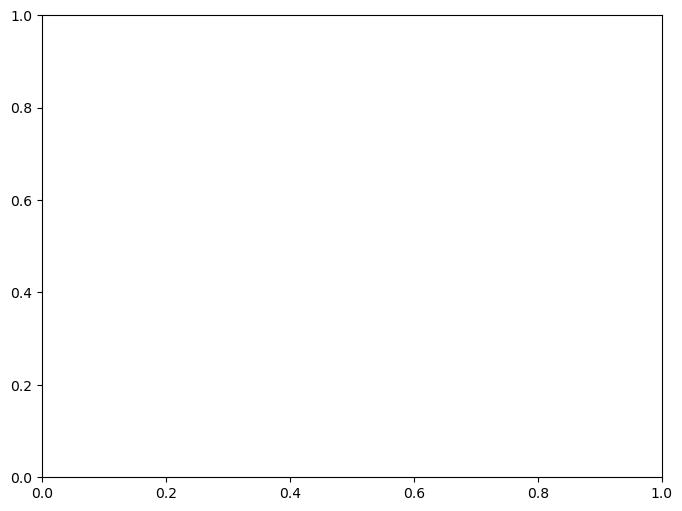

In [26]:
float_points_bis = np.array(float_points)
n = X_bits.shape[0]
l_s = 32 + 32            # bits par échantillon (X + Y)
c   = 1                  # pas de concaténation supplémentaire
l_c = c * l_s            # bits par chunk
n_c = n // c             # nombre de chunks = n

# on convertit chaque ligne binaire en un entier
chunks = []
for xb, yb in zip(X_bits, Y_bits):
    bitstr = ''.join(map(str, xb)) + ''.join(map(str, yb))
    chunks.append(int(bitstr, 2))
chunks = np.array(chunks, dtype=np.uint64)

# 2) Boucle sur l_b de 1 à l_c
etas = []
l_b_values = range(1, l_c + 1)

for l_b in l_b_values:
    shift = l_c - l_b
    # extraire la base (les l_b bits de poids forts)
    bases_bis = chunks >> shift
    
    # nombre de bases uniques
    n_b = len(np.unique(bases_bis))
    
    # longueur de l'ID de base
    l_id = math.ceil(math.log2(n_b)) if n_b > 1 else 1
    # longueur de la déviation
    l_d = l_c - l_b
    
    # taux de compression η
    numerator   = n_b * l_b + n_c * (l_id + l_d)
    denominator = n * l_s
    eta = numerator / denominator
    
    etas.append(eta)
    ks = range(2, 21)
    silh_scores = []

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
        labels = kmeans.fit_predict(float_points_bis)
        silh_scores.append(silhouette_score(float_points_bis, labels))

plt.figure(figsize=(8, 6))
plt.scatter(etas, silh_scores, c='navy', s=40)

for i, lb in enumerate(l_b_values):
    plt.text(etas[i], silh_scores[i], str(lb),
             fontsize=7, ha='right', va='bottom', color='darkred')

plt.xlabel("Taux de compression η (chunk)")
plt.ylabel("Meilleur silhouette (K-Means sur X_rec)")
plt.title("η vs Silhouette pour chaque l_b (bits de base)")
plt.grid(alpha=0.3)
plt.show()

# pas encore traité cette partie mais très bon par rapport aux anciennes données qu'on avait

In [32]:
def compute_centroids_with_weights(base_ids, deviations):
    """
    Calcule les centroïdes pour chaque base ID et associe un poids à chaque base.
    Le poids est défini comme le nombre de déviations associées à la base.

    Args:
        base_ids (list): Liste des IDs des bases.
        deviations (list): Liste des déviations associées.

    Returns:
        dict: Dictionnaire contenant les centroïdes pour chaque base ID.
        dict: Dictionnaire contenant les poids pour chaque base ID.
    """
    unique_ids = np.unique(base_ids)
    centroids = {}
    weights = {}

    for uid in unique_ids:
        # Récupérer les indices correspondant à l'ID courant
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        # Extraire les déviations associées
        selected_values = [deviations[i] for i in indices]

        # Convertir en entier, puis calculer la moyenne
        ints = [int(''.join(map(str, val)), 2) for val in selected_values]
        mean_int = round(np.mean(ints))

        # Reconvertir la moyenne en binaire
        mean_bits = [int(x) for x in bin(mean_int)[2:].zfill(len(selected_values[0]))]

        centroids[uid] = mean_bits
        weights[uid] = len(selected_values)

        """
        # Trouver manuellement min et max en comparant bit par bit
        min_val = selected_values[0]
        max_val = selected_values[0]

        for val in selected_values:
            min_val, _ = compare_bitwise(min_val, val)
            _, max_val = compare_bitwise(max_val, val)

        # Calculer la moyenne entre min et max (en entier)
        min_int = int(''.join(map(str, min_val)), 2)
        max_int = int(''.join(map(str, max_val)), 2)
        mean_int = (min_int + max_int) // 2  # Moyenne des deux entiers

        # Convertir la moyenne en binaire
        mean_bin = bin(mean_int)[2:]  # On enlève le préfixe '0b'
        
        # Calculer le centroïde comme la moyenne entre min et max
        centroid = [int(bit) for bit in mean_bin.zfill(len(min_val))]  # Compléter avec des zéros si nécessaire
        centroids[uid] = centroid

        # Associer un poids à la base (nombre de déviations associées)
        weights[uid] = len(selected_values)
        """
    return centroids, weights

# Exemple d'utilisation
centroids_with_weights, weights = compute_centroids_with_weights(base_ids, deviations)
print("Centroids with Weights:", centroids_with_weights)
print("Weights:", weights)

Centroids with Weights: {0: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1], 1: [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], 2: [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1], 3: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], 4: [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1], 5: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0], 6: [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,

In [33]:
# Reconstruction des points
reconstructed_points_bis = reconstruct_points(base_dict, centroids_with_weights)
print("Reconstructed Points:", reconstructed_points_bis[0])
print("Taille", len(reconstructed_points_bis))

Reconstructed Points: ([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])
Taille 41


In [34]:
# Conversion des points reconstruits en flottants
float_points_bis = convert_reconstructed_points_to_float(reconstructed_points)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

Points reconstruits en flottants :
(11.972963333129883, 15.41586971282959)
(7.360812664031982, 11.99785041809082)
(3.1117234230041504, 2.784640073776245)
(4.759212493896484, 3.5422041416168213)
(2.873872756958008, 1.1593536138534546)
(3.589897632598877, 4.573168754577637)
(4.615873336791992, 1.8459888696670532)
(4.68592643737793, 4.661465167999268)
(4.577362060546875, 0.3428631126880646)
(16.685453414916992, 9.619433403015137)
(13.182450294494629, 1.828247308731079)
(12.875362396240234, 0.287776917219162)
(13.2017822265625, 2.1218414306640625)
(13.213839530944824, 0.7945922017097473)
(12.342977523803711, -0.8806813359260559)
(12.299148559570312, -0.004492097068578005)
(13.230143547058105, 0.20986798405647278)
(11.302947044372559, 0.0007632955675944686)
(2.548283100128174, 16.326078414916992)
(1.5160528421401978, 16.150644302368164)
(1.550552248954773, 11.697509765625)
(0.7793450355529785, 15.265892028808594)
(0.7290412187576294, 16.36651611328125)
(0.3900730609893799, 17.01411056518554

In [35]:
# Conversion des points reconstruits en flottants
float_points = convert_reconstructed_points_to_float(reconstructed_points_bis)

# Affichage des résultats
print("Points reconstruits en flottants :")
for point in float_points:
    print(point)

Points reconstruits en flottants :
(12.271979331970215, 9.576903343200684)
(7.5386738777160645, 14.35990047454834)
(3.3613462448120117, 3.2103774547576904)
(4.50935697555542, 2.154266119003296)
(3.205388069152832, 1.4573379755020142)
(3.4988245964050293, 7.106757164001465)
(4.594401836395264, 1.1084935665130615)
(4.68592643737793, 4.661465167999268)
(4.577362060546875, 0.3428631126880646)
(16.50608253479004, 12.79281997680664)
(13.24374771118164, 1.527629017829895)
(13.30145263671875, 0.2983788847923279)
(13.142644882202148, 2.073204278945923)
(13.309896469116211, 0.975827157497406)
(12.342977523803711, -0.8806813359260559)
(12.299148559570312, -0.004492097068578005)
(13.230143547058105, 0.20986798405647278)
(11.302947044372559, 0.0007632955675944686)
(2.4506874084472656, 16.90087127685547)
(1.5111027956008911, 22.82960319519043)
(1.393951654434204, 14.442752838134766)
(0.7678969502449036, 13.49217414855957)
(0.739427387714386, 28.8681583404541)
(0.3900730609893799, 17.014110565185547)

In [38]:
def apply_kmeans_with_weights_and_plot(float_points, weights, n_clusters):
    """
    Applique K-Means sur les points reconstruits en tenant compte des poids et affiche les clusters ainsi que les métriques.

    Args:
        float_points (list): Liste des points sous forme de tuples de flottants [(X1, Y1), (X2, Y2), ...].
        weights (dict): Dictionnaire contenant les poids associés à chaque base ID.
        n_clusters (int): Nombre de clusters pour K-Means.
    """
    # Conversion en tableau NumPy
    points_array = np.array(float_points)

    # Création d'un tableau de poids aligné avec les points
    weight_array = np.array([weights[base_id] for base_id in range(len(float_points))])

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Initialisation et application de K-Means avec les poids
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_array, sample_weight=weight_array)

    # Mesurer le temps d'exécution
    end_time = time.time()
    execution_time = end_time - start_time

    # Centres des clusters
    cluster_centers = kmeans.cluster_centers_

    # Inertie (somme des distances intra-cluster)
    inertia = kmeans.inertia_

    # Score de silhouette (sans poids, car non supporté)
    if n_clusters > 1:
        silhouette = silhouette_score(points_array, labels)
    else:
        silhouette = None  # Le score de silhouette n'est pas défini pour un seul cluster

    # Afficher les résultats
    print("Centres trouvés par K-Means :")
    print(cluster_centers)
    print("\nInertie (somme des distances intra-cluster) :", inertia)
    if silhouette is not None:
        print("Score de silhouette :", silhouette)
    print(f"\nTemps d'exécution de K-Means : {execution_time:.4f} secondes")

    # Visualisation des clusters
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        # Sélectionner les points appartenant au cluster actuel
        cluster_points = points_array[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", s=50, alpha=0.7)

    # Afficher les centres des clusters
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X', label="Centres des Clusters")

    # Ajouter des détails au graphique
    plt.title("Clustering avec K-Means (avec poids)", fontsize=16)
    plt.xlabel("Coordonnée X", fontsize=14)
    plt.ylabel("Coordonnée Y", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Afficher le graphique
    plt.show()

Centres trouvés par K-Means :
[[ 3.88189075  2.75456582]
 [ 7.45610046 27.21133804]
 [12.7338815   9.92773061]
 [19.65547705  1.59757994]
 [ 4.84587444 15.80682784]
 [13.17911818  1.53283062]
 [ 1.36012282 24.01105964]]

Inertie (somme des distances intra-cluster) : 2949.4980053323166
Score de silhouette : 0.6236381069416842

Temps d'exécution de K-Means : 0.0052 secondes


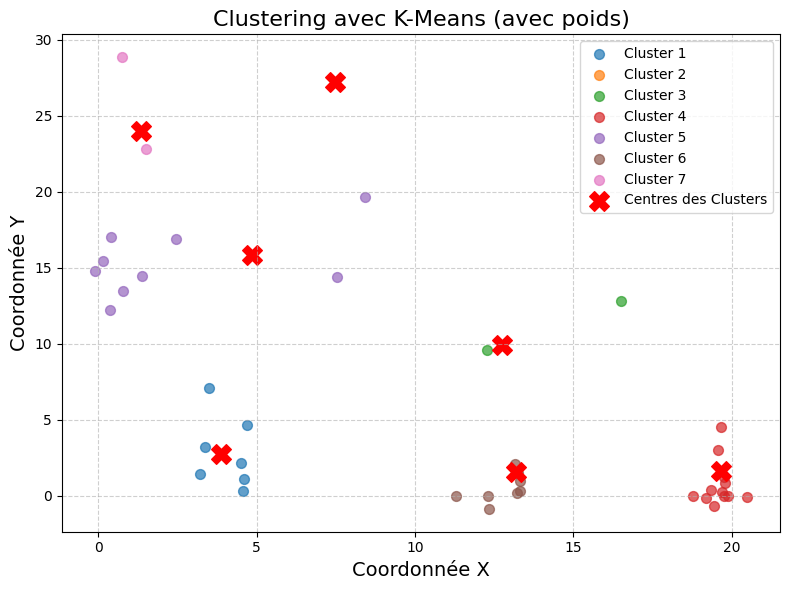

In [41]:
apply_kmeans_with_weights_and_plot(float_points, weights, n_clusters=n_clusters)

In [25]:
def compute_weighted_centroids(base_dict, base_ids, deviations, base_bits=9):
    unique_ids = np.unique(base_ids)
    centroids = {}
    max_of_max_deviations = {}
    mean_of_max_deviations = {}
    prod_of_max_deviations = {}

    id_to_bases = {uid: [] for uid in unique_ids}
    for base, bid in base_dict.items():
        if bid in id_to_bases:
            id_to_bases[bid].append(base)

    for uid in unique_ids:
        base_tuple = id_to_bases[uid][0]  # base = 18 bits (9 + 9)
        base_x = list(base_tuple[:base_bits])
        base_y = list(base_tuple[base_bits:2 * base_bits])
        base_bits_full = base_x + base_y  # 18 bits

        # Récupérer les déviations (46 bits) associées à l'uid
        indices = [i for i, x in enumerate(base_ids) if x == uid]
        selected_deviations = [deviations[i] for i in indices]

        # Initialisation
        min_dev = selected_deviations[0]
        max_dev = selected_deviations[0]

        for dev in selected_deviations:
            min_dev, _ = compare_bitwise(min_dev, dev)
            _, max_dev = compare_bitwise(max_dev, dev)

        # Moyenne bitwise sur l'ensemble des 46 bits
        min_int = int(''.join(map(str, min_dev)), 2)
        max_int = int(''.join(map(str, max_dev)), 2)
        mean_int = (min_int + max_int) // 2
        mean_dev_bin = bin(mean_int)[2:].zfill(46)
        mean_dev = [int(b) for b in mean_dev_bin]

        # Centroïde complet = base_x + base_y + moyenne des déviations
        centroid = mean_dev
        centroids[uid] = centroid

        # Pour le poids "max of max" : concat base_x + max_dev_x, base_y + max_dev_y
        max_dev_x = [val[:23] for val in selected_deviations]
        max_dev_y = [val[23:] for val in selected_deviations]

        # Trouver les plus grandes déviations X et Y
        max_dx = max_dev_x[0]
        max_dy = max_dev_y[0]
        for dx, dy in zip(max_dev_x, max_dev_y):
            _, max_dx = compare_bitwise(max_dx, dx)
            _, max_dy = compare_bitwise(max_dy, dy)

        # Concat binaire
        base_x_str = ''.join(map(str, base_x))
        base_y_str = ''.join(map(str, base_y))
        max_dx_str = ''.join(map(str, max_dx))
        max_dy_str = ''.join(map(str, max_dy))

        concat_x = int(base_x_str + max_dx_str, 2)
        concat_y = int(base_y_str + max_dy_str, 2)
        
        maximum_weight = concat_x if concat_x > concat_y else concat_y
        mean_weight = (concat_x + concat_y)//2
        prod_weight = (concat_x * concat_y)//1000000

        max_of_max_deviations[uid] = maximum_weight
        mean_of_max_deviations[uid] = mean_weight
        prod_of_max_deviations[uid] = prod_weight//10000

        #print(f"UID: {uid}, Centroid: {centroid}, MaxWeight: , MeanWeight: {mean_weight:.4f}, ProdWeight: {prod_weight:.4f}")

    return centroids, max_of_max_deviations, mean_of_max_deviations, prod_of_max_deviations


In [26]:
print("Calcul des centroids et de leur poids ")
centroids2, max_of_max, mean_of_max, prod_of_max= compute_weighted_centroids(base_dict, base_ids, deviations)
reconstructed_points_2 = reconstruct_points(base_dict, centroids2)
float_points = convert_reconstructed_points_to_float(reconstructed_points_2)

print("Centroids: ", float_points)
print("Weigths max of max: ", max_of_max)
print("Weigths mean of max: ", mean_of_max)
print("Weigths product of max: ",prod_of_max)

Calcul des centroids et de leur poids 
Centroids:  [(11.972963333129883, 15.41586971282959), (7.360812664031982, 11.99785041809082), (3.1117234230041504, 2.784640073776245), (4.759212493896484, 3.5422041416168213), (2.873872756958008, 1.1593536138534546), (3.589897632598877, 4.573168754577637), (4.615873336791992, 1.8459888696670532), (4.68592643737793, 4.661465167999268), (4.577362060546875, 0.3428631126880646), (16.685453414916992, 9.619433403015137), (13.182450294494629, 1.828247308731079), (12.875362396240234, 0.287776917219162), (13.2017822265625, 2.1218414306640625), (13.213839530944824, 0.7945922017097473), (12.342977523803711, -0.8806813359260559), (12.299148559570312, -0.004492097068578005), (13.230143547058105, 0.20986798405647278), (11.302947044372559, 0.0007632955675944686), (2.548283100128174, 16.326078414916992), (1.5160528421401978, 16.150644302368164), (1.550552248954773, 11.697509765625), (0.7793450355529785, 15.265892028808594), (0.7290412187576294, 16.36651611328125)

K-means sur les maximum de déviation
Méthode 1: Moyennne des Maximums de déviations
Centres trouvés par K-Means :
[[12.63613437  0.35312412]
 [ 0.78516987 15.30793052]
 [ 4.03028082  2.70828342]
 [19.58238936  0.54723991]
 [ 7.89972241 27.67932521]
 [ 9.67179799 13.71049881]
 [16.68545341  9.6194334 ]]

Inertie (somme des distances intra-cluster) : 125764902243.16547
Score de silhouette : 0.7087732363611863

Temps d'exécution de K-Means : 0.0038 secondes


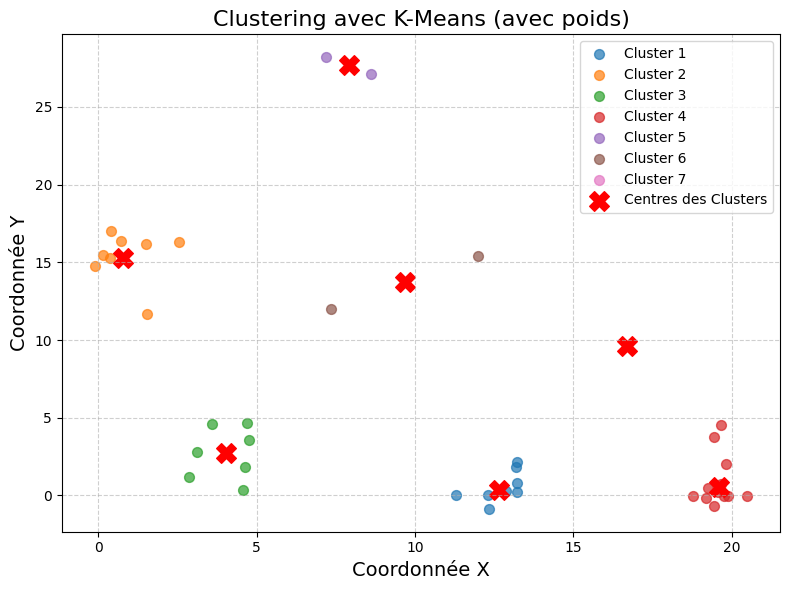

In [27]:
print("K-means sur les maximum de déviation")
print("Méthode 1: Moyennne des Maximums de déviations")
apply_kmeans_with_weights_and_plot(float_points, mean_of_max, n_clusters=n_clusters)

Méthode 2: produit des des de déviations
Centres trouvés par K-Means :
[[ 0.70460345 15.25676105]
 [19.5848794   0.36963617]
 [ 4.03000283  2.71522874]
 [12.58772896  0.22056074]
 [ 7.89996791 27.67914185]
 [ 9.67671782 13.71414485]
 [16.68545341  9.6194334 ]]

Inertie (somme des distances intra-cluster) : 14489660604.265074
Score de silhouette : 0.7087732363611863

Temps d'exécution de K-Means : 0.0034 secondes


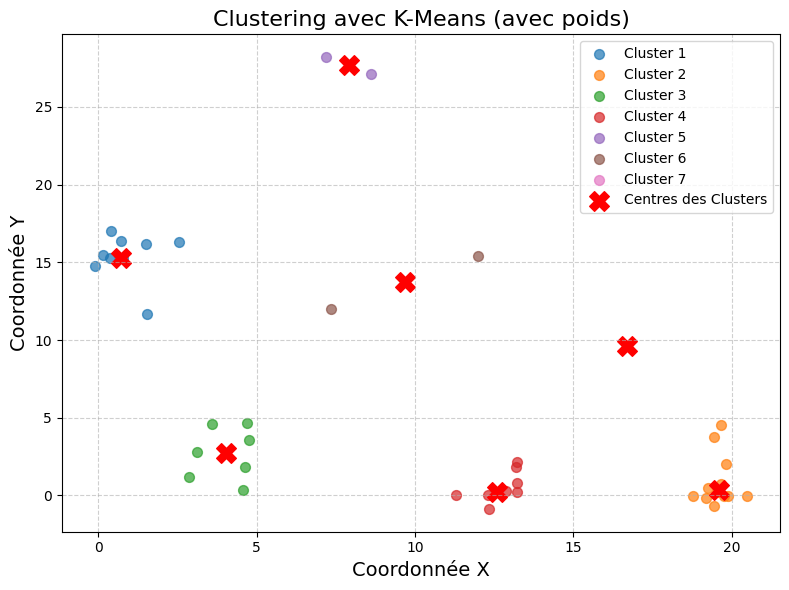

In [28]:
print("Méthode 2: produit des des de déviations")
apply_kmeans_with_weights_and_plot(float_points, prod_of_max, n_clusters=n_clusters)

Méthode 3: Maximum des maximums de deviations
Centres trouvés par K-Means :
[[ 0.70644096 15.26344078]
 [19.58443048  0.37742402]
 [ 4.03136155  2.70247353]
 [12.58260765  0.22511399]
 [ 7.89953983 27.67946158]
 [ 9.66886042 13.70832181]
 [16.68545341  9.6194334 ]]

Inertie (somme des distances intra-cluster) : 134157468143.27042
Score de silhouette : 0.7087732363611863

Temps d'exécution de K-Means : 0.0021 secondes


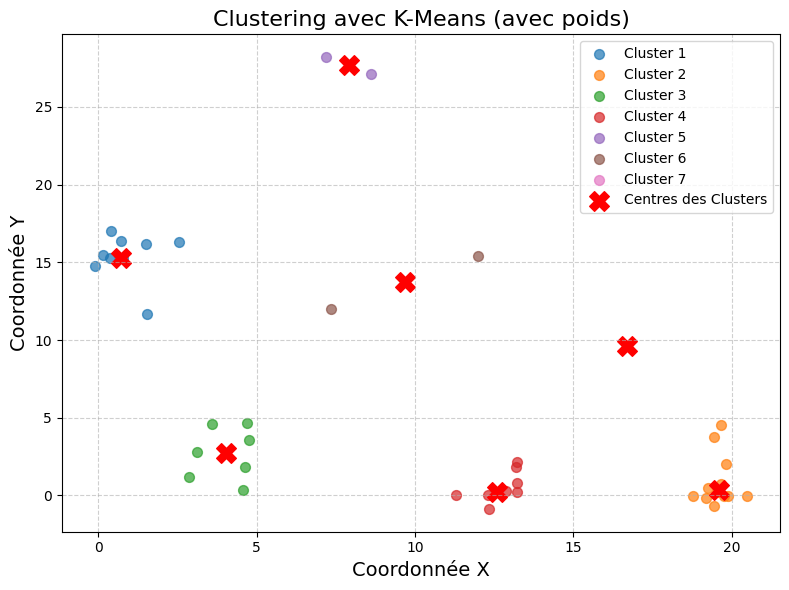

In [29]:
print("Méthode 3: Maximum des maximums de deviations")
apply_kmeans_with_weights_and_plot(float_points, max_of_max, n_clusters=n_clusters)